# **Presentación**

## Universidad Nacional de Rosario

### **Tecnicatura Universitaria en Inteligencia Artificial**

### IA42 - Procesameinto del Lenguaje Natural

---

**Fecha**: 02/11/2023

**Integrantes**:
- Ferrucci Constantino
- Giampaoli Fabio

**Docentes**:
- Juan Pablo Manson
- Alan Geary
- Andrea Cavallo
- Ariel D'Alessandro

---

## Resumen

En presente trabajo tiene como finalidad la resolución práctica de ejercicios propuestos por la asignatura `Procesamiento del Lenguaje Natural` con el fin de afianzar los contenidos teoricos prácticos brindados durante el cursado de las primeras tres unidades.

Los ejercicios son de naturaleza continua. Es decir, el desarrollo de un ejercicio requiere la resolcuión de los anteriores. Los mismos consisten principalmente en tareas de procesamiento de texto extraidos de fuentes de noticias de distintas categorias.

Durante el desarrollo del trabajo, se presentan soluciones y problematicas que requieren de soluciones con Web Scraping, depuración de texto, transformaciones vectoriales y entrenamiento y uso de modelos de lenguaje.

# **Entorno**

En este item se pretende generar e importar clases y funciones que seran de utilidad para el desarrollo de los ejercicios.

### Librerias

Para desarrollar las funcionalidades requeridas es necesario hacer uso de distintos paquetes y funciones que ofrece Python para procesar datos y lenguaje.

In [1]:
%%capture
!pip install sentence-transformers transformers
!pip install unidecode pattern
!python -m spacy download es_core_news_sm

In [2]:
# web scraping
import requests
from bs4 import BeautifulSoup

# visualizaciones
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import clear_output
import plotly.express as px

# procesamiento de datos
import pandas as pd
import re
from random import choice
import spacy

# modelos de lenguaje
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import T5Tokenizer, T5ForConditionalGeneration

# otros modelos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

# depuracion de texto
from nltk.corpus import stopwords
from pattern.es import singularize
import networkx as nx
import unidecode
from nltk.stem.snowball import SnowballStemmer

### Configuración inicial

Las siguientes líneas de código logran establecer configuraciones iniciales que seran de utilidad para el transcurso de todo el trabajo.

In [3]:
nltk.download('stopwords') # descarga de stopwords
spanish_stop_words = stopwords.words('spanish')
pd.set_option('display.max_colwidth', None)  # Esto muestra el máximo de anchura de una columna de un dataframe
nlp = spacy.load('es_core_news_sm')
stemmer = SnowballStemmer('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Definición de clases

La siguiente clase se define con el fin facilitar la obtención y tratamiento de la información obtenida de las paginas web.

In [4]:
class Noticia:
  def __init__(self, titulo, texto, url):
    # define la estructura de las noticias
    self.titulo = titulo
    self.texto = texto
    self.url = url

  def get_titulo(self):
    return self.titulo

  def get_texto(self):
    return self.texto

  def get_url(self):
    return self.url

  def __str__(self):
    # impresión amigable del objeto, muestra sus propiedades de forma ordenada
    noticia = f'{self.titulo} - ({self.url})\n\n{self.texto}'
    return noticia

La siguiente clase tiene la intención de generar metodos que permitan manipular el conjunto de noticias obtenidas para cada clase.

In [5]:
class Categoria:
  def __init__(self, categoria, url, id):
    # estructura de una categoria
    self.categoria = categoria
    self.url = url
    self.id = id
    self.noticias = []
    self.url_principal = url[: url.index('.com') + 4]

  def set_noticias(self, noticias):
    # almacenar las noticias en el objeto
    self.noticias = noticias

  def add_noticia(self, noticia):
    # añadir una nueva
    self.noticias.append(noticia)

  def get_noticias(self):
    return self.noticias

  def get_noticia(self, num_index):
    return self.noticias[num_index]

  def __str__(self):
    # formato de impresión ordenado de las noticias de una categoria
    if len(self.noticias) == 0:
      return 'No hay noticias cargadas.'
    texto = ''
    for i, noticia in enumerate(self.noticias):
      texto += f'{i + 1} - {noticia.get_titulo()} ({noticia.get_url()})\n'
    return texto

### Definición de funciones

In [6]:
def find_noticia(categoria, class_=None, label=None):
  args = {'class_': class_} if class_ else {'name': label}
  request = requests.get(categoria.url).text
  soup = BeautifulSoup(request, 'html')
  urls_noticias = []

  for etiqueta in soup.find_all(**args)[:10]:
    while etiqueta and etiqueta.name != 'a':
      etiqueta = etiqueta.parent
    urls_noticias.append(categoria.url_principal + etiqueta.get('href'))
  noticias = []

  for url_noticia in urls_noticias:
    request_noticia = requests.get(url_noticia).text
    soup_noticia = BeautifulSoup(request_noticia, 'html')
    titulo = soup_noticia.find_all('h1')[0].text
    texto = '\n'.join([p.text for i, p in enumerate(soup_noticia.find_all('p')[1:]) if not p.text.startswith('Por ') or i != 0])
    noticia = Noticia(titulo, texto, url_noticia)
    noticias.append(noticia)

  categoria.set_noticias(noticias)
  return None


def plot_custom_histogram(data, bins=10, title="Histograma", x_label="Valores", y_label="Frecuencia",
                          color='royalblue', edgecolor='black', alpha=0.7, grid=True, figsize=(8, 6)):
  """
  Crea un histograma personalizado a partir de una lista de datos.
  args:
    data: Lista de datos para el histograma.
    bins: Número de contenedores (bins) para el histograma (por defecto, 10).
    title: Título del gráfico.
    x_label: Etiqueta del eje x.
    y_label: Etiqueta del eje y.
    color: Color de las barras del histograma.
    edgecolor: Color del borde de las barras.
    alpha: Transparencia de las barras (0.0 - 1.0).
    grid: Mostrar cuadrícula en el gráfico.
    figsize: Tamaño de la figura (ancho, alto).
  returns:
    None
  """
  plt.figure(figsize=figsize)
  plt.hist(data, bins=bins, color=color, edgecolor=edgecolor, alpha=alpha)
  plt.title(title, fontsize=16)
  plt.xlabel(x_label, fontsize=12)
  plt.ylabel(y_label, fontsize=12)

  if grid:
      plt.grid(True, linestyle='--', alpha=0.7)

  plt.show()


def extract_category_labels(categories_list):
  labels = {categoria.id: categoria.categoria for categoria in categorias}
  return labels


def give_labels_to_data(categorias):
  data = []
  for categoria in categorias:
    for noticia in categoria.get_noticias():
      data.append((categoria.id, noticia.titulo))
  # data = [(categoria.id, noticia.titulo) for noticia in categoria.get_noticias() for categoria in categorias]
  return data


def extract_longitud_noticias(categorias):
  # valores = [len(noticia.texto) for noticia in categoria.get_noticias() for categoria in categorias]
  data = []
  for categoria in categorias:
    for noticia in categoria.get_noticias():
      data.append(len(noticia.texto))
  return data


def split_values(data):
  X = [text.lower() for label, text in data]
  y = [label for label, text in data]
  return X, y


def preprocess_text(text):
  stop_words = stopwords.words('spanish')
  text = text.lower()
  text = ''.join([c for c in text if c.isalnum() or c.isspace()])
  words = text.split()
  words = [word for word in words if word not in stop_words]
  return ' '.join(words)


def extract_text_from_noticias(categorias):
  noticias = {categoria.id: [noticia.get_texto() for noticia in categoria.get_noticias()] for categoria in categorias}
  return noticias


def extract_preprocessed_text_from_noticias(categorias):
  noticias = {categoria.id: [preprocess_text(noticia.get_texto()) for noticia in categoria.get_noticias()] for categoria in categorias}
  return noticias


def graficar_nube_palabras(noticias):
  for category, preprocessed_texts in noticias.items():

    # Conteo de palabras en la categoría
    vectorizer = CountVectorizer()
    word_counts = vectorizer.fit_transform(preprocessed_texts)

    # Crea una nube de palabras para la categoría
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vectorizer.vocabulary_)

    # Muestra la nube de palabras de la categoría
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Categoria: {labels[category]}')
    plt.show()


def get_similarity_cos_df(puntuaciones):
  pares = []
  for i in range(len(puntuaciones)-1):
    for j in range(i+1, len(puntuaciones)):
      pares.append({'index': [i, j], 'score': puntuaciones[i][j]})

  # Ordenamos las puntuaciones en orden decreciente
  pares = sorted(pares, key=lambda x: x['score'], reverse=True)
  tabla = []
  # Añadimos las filas a la tabla
  for par in pares[0:10]:
    i, j = par['index']
    tabla.append([noticias_deportes[i], noticias_deportes[j], f"{par['score']:.4f}"])
  columnas = ['Titulo 1', 'Titulo 2', 'Puntuación']
  tabla

  df = pd.DataFrame(tabla, columns=columnas)
  return df




# **Ejercicios**

Contamos con cinco ejercicios en total. En cada desplegable de detalla en el uniciado de cada uno, su desarrollo y sus concluciones individuales.

Es importante considerar que los ejercicios son dependientes entre si, por lo que se recomienda entenderlos y replicarlos de forma ordenada.

### ***Primer ejercicio***  

---

Construir un dataset haciendo web scraping de páginas web de su elección.

- Definir 4 categorías de noticias/artículos.
- Para cada categoría, extraer los siguientes datos de 10 noticias diferentes:
- url (sitio web donde se publicó el artículo)
- título (título del artículo)
- texto (contenido del artículo)

Utilizando los datos obtenidos construya el dataset en formato csv.

---

#### Obtención de noticias

En la siguiente celda se inicializan las clases de categorias, cada una con sus atributos de Nombre, Url y Id.

Se elijieron las categorias mostradas debajo. De cada categoria se encuentra en internet la url de las paginas de disitntas fuentes que almacenan noticias correspondientes a cada categoria.

In [7]:
politica = Categoria('Politica', 'https://infobae.com/politica/', 0)
deporte = Categoria('Deporte', 'https://www.infobae.com/america/deportes/espn/', 1)
pelicula = Categoria('Pelicula', 'https://www.infobae.com/tag/peliculas/', 2)
tecnologia = Categoria('Tecnologia', 'https://www.infobae.com/tag/perfiles-tecno/', 3)

categorias = [politica, deporte, pelicula, tecnologia]

Se define una función externa cuya utilidad es la de hacer consultas a la web de una categoria dada.

A la consulta se le pasa por parametro la clase del elemnto que distingue a cada noticia en particular. Mediante investigación con las herramientas de desarrollador del motor de busqueda, se encuentra que cada fuente indentifica las noticias con una clase en particular.

Tambien es posible buscar mediante etiquetas los objetos que indentifican a cada noticia en la pagina web.



In [8]:
def find_noticia(categoria, class_=None, label=None):
    # toma la etiqueta o la clase de cada noticia
    args = {'class_': class_} if class_ else {'name': label}

    # abre la consulta a la web
    request = requests.get(categoria.url).text
    soup = BeautifulSoup(request, 'html')

    # se almacena la url de cada noticia particular
    urls_noticias = []

    for etiqueta in soup.find_all(**args)[:10]: # se filtran solo las primeras 10 noticias
        while etiqueta and etiqueta.name != 'a': # de cada noticia se recorre la estructura para encontrar su link
            etiqueta = etiqueta.parent
        urls_noticias.append(categoria.url_principal + etiqueta.get('href'))

    # se almacena de cada noticia su contenido y otras propiedades de las mismas en el objeto correspondiente
    noticias = []

    for url_noticia in urls_noticias:
        # consulta al url de la noticia particular
        request_noticia = requests.get(url_noticia).text
        soup_noticia = BeautifulSoup(request_noticia, 'html')
        # extraccion de atributos
        titulo = soup_noticia.find_all('h1')[0].text
        texto = '\n'.join([p.text for i, p in enumerate(soup_noticia.find_all('p')[1:]) if not p.text.startswith('Por ') or i != 0])
        noticia = Noticia(titulo, texto, url_noticia)
        # almacenamiento en memoria
        noticias.append(noticia)

    # almacenamiento en el objeto categoria
    categoria.set_noticias(noticias)
    return None

De esta manera, una vez que se conocen las clases que indetifican a cada noticia de la url general, podemos aplicar esta funcion para cargar en memoria las 10 noticias correspondientes a cada categoria.

Notar que en este caso la clase para la segunda categoria es distinta a las demas debido a que cambia la fuente de origen, por lo que la estructura de la pagina es distinta.

In [9]:
find_noticia(politica, 'feed-list-card-headline-lean')
find_noticia(deporte, 'story-card-hl')
find_noticia(pelicula, 'feed-list-card-headline-lean')
find_noticia(tecnologia, 'feed-list-card-headline-lean')

#### Visualización

En la siguiente celda desplegable se puede visualizar que se han cargado correctamente todas las noticas de cada categoria.

In [10]:
# Todas las noticias de cada categoria
for categoria in categorias:
  print(f'Noticias de {categoria.categoria} ({categoria.url})')
  print(categoria)

Noticias de Politica (https://infobae.com/politica/)
1 - Elecciones 2023, en vivo: “Perdimos por paliza, tuvimos una pésima candidata y una pésima campaña”, aseguró un exministro de Mauricio Macri (https://infobae.com/politica/2023/10/29/elecciones-2023-en-vivo-todas-las-noticias-rumbo-al-balotaje-minuto-a-minuto/)
2 - Massa compartió con Kicillof la ceremonia de jura de Jaldo como gobernador de Tucuman y envió otra señal para sumar al voto radical (https://infobae.com/politica/2023/10/29/massa-kicillof-e-insfran-participaron-del-acto-de-asuncion-de-jaldo-como-gobernador-de-tucuman/)
3 - Macri volverá a hablar este domingo, se consolida el pacto con Milei y se rompe más una oposición ya rota (https://infobae.com/politica/2023/10/29/macri-volvera-a-hablar-este-domingo-se-consolida-el-pacto-con-milei-y-se-rompe-mas-una-oposicion-rota/)
4 - Jaime Durán Barba: “Supongo yo que Macri no habrá leído el programa de Milei” (https://infobae.com/politica/2023/10/29/jaime-duran-barba-supongo-yo-qu

In [11]:
# ejemplo del contenido de una noticia
print(tecnologia.get_noticia(1))

Cómo triunfar en Youtube: Alejandro Gowland, líder de Creative Works de Google, reveló el secreto - (https://www.infobae.com/tecno/2023/10/06/es-clave-que-las-marcas-conecten-con-su-publico-a-traves-de-youtube-shorts/)

En un mar de contenido en línea, la creatividad permite destacar y diferenciarse de otros. Con esa premisa entrevistamos a Alejandro Gowland, director de Creative Works de Google para Hispanoamérica, quien habló con Infobae en exclusiva sobre la importancia de que una idea conecte con la audiencia. 
Asimismo, es importante que esa idea tenga la posibilidad de expandirse, para que pueda sostenerse a largo plazo o al menos por un período de tiempo razonable. “No hay que quedarse siempre con lo mismo”, subraya el ejecutivo de Google.
Gowland añade que es fundamental conocer a la audiencia y saber cómo se comporta: “hay un estudio interesante que nos cuenta que nuestro consumo en YouTube, en promedio, es de 15 verticales de contenido, es decir, a mí no solo me gusta el teni

La siguiente función tiene propocito de generar un historigrama de utilidad para dar una intuición de las longitudes de las noticias.

In [12]:
def plot_custom_histogram(data, bins=15, title="Histograma", x_label="Valores", y_label="Frecuencia", color='skyblue', edgecolor='black', alpha=0.7, grid=True, figsize=(14, 6)):
  plt.figure(figsize=figsize)
  plt.hist(data, bins=bins, color=color, edgecolor=edgecolor, alpha=alpha)
  plt.title(title, fontsize=16)
  plt.xlabel(x_label, fontsize=12)
  plt.ylabel(y_label, fontsize=12)

  if grid:
      plt.grid(True, linestyle='--', alpha=0.7)

  plt.show()

La siguiente función tiene proposito de extraer la longitud de cada noticia de cada categoria y almacenarla en una lista.

In [13]:
def extract_longitud_noticias(categorias):
  # valores = [len(noticia.texto) for noticia in categoria.get_noticias() for categoria in categorias]
  data = []
  for categoria in categorias:
    for noticia in categoria.get_noticias():
      data.append(len(noticia.texto)) # longitud de una noticia
  return data

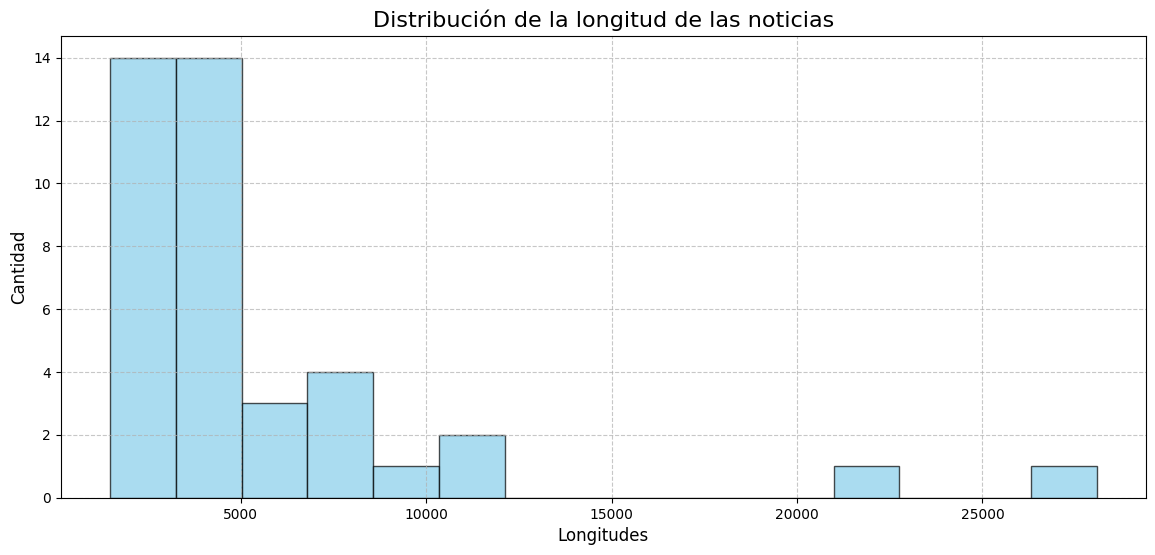

In [14]:
valores = extract_longitud_noticias(categorias) # metodo de obtencion de longitudes

plot_custom_histogram(valores, title="Distribución de la longitud de las noticias", x_label="Longitudes", y_label="Cantidad")

Este grafico sugiere que las longitudes de las noticias son mas comunes entres 2500 y 5000 caracteres.

#### Formato tabular

Para almacenar toda esta información en formato tabular haremos use de la siguiente función

In [15]:
def categorias_a_dataframe(categorias):
    # Crear una lista vacía para almacenar los datos
    data = []

    # Recorrer cada categoría
    for categoria in categorias:
        # Recorrer cada noticia en la categoría
        for noticia in categoria.get_noticias():
            # Añadir los datos de la noticia al DataFrame
            data.append([categoria.categoria, noticia.get_titulo(), noticia.get_url(), noticia.get_texto()])

    # Crear un DataFrame con los datos
    df = pd.DataFrame(data, columns=['Categoria', 'Titulo', 'URL', 'Texto'])

    return df

In [16]:
df_noticias = categorias_a_dataframe(categorias)
df_noticias.head(1)

Categoria  \
0  Politica   

                                                                                                                                        Titulo  \
0  Elecciones 2023, en vivo: “Perdimos por paliza, tuvimos una pésima candidata y una pésima campaña”, aseguró un exministro de Mauricio Macri   

                                                                                                                     URL  \
0  https://infobae.com/politica/2023/10/29/elecciones-2023-en-vivo-todas-las-noticias-rumbo-al-balotaje-minuto-a-minuto/   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [17]:
df_noticias.to_csv('df_noticias.csv')

---

### ***Segundo ejercicio***

---

Utilizando los datos de título y categoría del dataset del ejercicio anterior, entrenar un
modelo de clasificación de noticias en categorías específicas

---

#### Dataset

Como es de interes que el modelo pueda pueda clasificar la categoria de un ritulo dado, nuestra variable objetivo para la clasificación seria 'Categoria'. Pero antes se normaliza el texto a formato minuscula.

In [18]:
# normalizar a formato miniscula
df_noticias['Titulo'] = df_noticias['Titulo'].str.lower()
df_noticias['Categoria'] = df_noticias['Categoria'].str.lower()

# separacion de variables
X = df_noticias['Titulo']
y = df_noticias['Categoria']

Separamos el dataset en datos de entrenamiento y validación. De esta forma, podremos entrenar el modelo de clasificación y luego obtener sus predicciones para validarlas.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Vectorización

Para que el modelo pueda interpretar los datos de este conjunto en su naturaleza textual, seria necesario llevar los datos a un espacio vectorial numerico.

En este caso se selecciona el vectorizador TF-IDF, ya que el mismo tinene la ventaja de que escala hacia abajo el impacto de las palabras que ocurren con mucha frecuencia en un corpus dado y que son, por lo tanto, menos informativas que las características que ocurren en una pequeña fracción del corpus de entrenamiento.

En este caso, al clisificar noticias basándose en sus títulos y categorías, TF-IDF es útil porque permitire determinar qué palabras son las más descriptivas para cada categoría.

In [20]:
vectorizer = TfidfVectorizer(stop_words=spanish_stop_words) # limpiamos los textos eliminando las stopwords

Primero se entrena el vectorizador solo con los datos de entrenamiento, y luego se transforman ambos conjuntos.

In [21]:
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

En el siguiente gráfico podemos visualizar en una espacio tridimensional la distribución de cada titulo en el espacio. Notar que se reduce la dimensionalidad del espacio usando Analisis de componentes principales con el fin de permitir la visualización.

In [22]:
# Crear el objeto PCA y ajustarlo a los datos
pca = PCA(n_components=3)
X_test_pca = pca.fit_transform(X_test_vectorized.toarray())

# Crear un DataFrame con los datos transformados
df_pca = pd.DataFrame(data = X_test_pca, columns = ['PC1', 'PC2', 'PC3'])
df_pca['Titulo'] = df_noticias['Titulo'].str.slice(0, 10)  # recorta los titulos a 10 caracteres para no invadir el grafico

# Crear un gráfico de dispersión 3D interactivo
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', text='Titulo')
fig.show()

#### Modelo

Se utiliza un modelo de regresión logistica debido a su capacidad de clasificacion multiclase.

In [23]:
model = LogisticRegression(max_iter=10000, solver='lbfgs', penalty='l2')

# entrenamiento con el conjunto apropiado
model.fit(X_train_vectorized, y_train)

LogisticRegression(max_iter=10000)

Ahora es posible predecir la categoria a la que pertenecen el conjunto de titulos reservados para validación, y obtener metricas de que preciso es el modelo a la hora de clasificar.

In [24]:
# hacemos predicciones de las categorias
y_pred_LR = model.predict(X_test_vectorized)

# veamos las predicciones
preds = pd.DataFrame()
preds['X_test'] = X_test
preds['y_pred_LR'] = y_pred_LR

display(preds)

,X_test,y_pred_LR
19,la arrogante sentencia de cristiano ronaldo luego sumar más goles en el año que haaland y mbappé,politica
16,liga de quito venció por penales a fortaleza y se consagró campeón de la copa sudamericana,tecnologia
15,candidato a gol del año: harry kane hizo historia al anotar desde atrás de mitad de cancha en el 8-0 del bayern múnich,tecnologia
26,la precuela de terror que llevó a la fama a mike flanagan está en netflix,pelicula
4,dos diputados que apoyaron a juan schiaretti confirmaron que votarán por massa: “no podemos ser neutrales”,politica
12,"los dos goles de matías soule en la derrota del frosinone: gambetas, robo y una definición indescifrable",tecnologia
37,perfiles tecno | cómo la inteligencia artificial ayuda a las empresas y la creación de contenido seo,tecnologia
27,salud y corrupción: emily blunt y chris evans revelan el lado oscuro de las farmacéuticas en esta película,pelicula


Notamos que en algunos registros clasifica incorrectamente, pero en general tiene buenos resultados. Veamos las metricas del modelo.

In [25]:
# este metodo retorna todas las metricas de utilidad para clasificación de cada clase
report_LR = classification_report(y_test, y_pred_LR, zero_division=1, output_dict=True)
df_report_LR = pd.DataFrame(report_LR).transpose()

print("\nReporte de clasificación Regresión Logística:")
display(df_report_LR)


Reporte de clasificación Regresión Logística:


,precision,recall,f1-score,support
deporte,1.00000,0.00,0.000000,4.0
pelicula,1.00000,1.00,1.000000,2.0
politica,0.50000,1.00,0.666667,1.0
tecnologia,0.25000,1.00,0.400000,1.0
accuracy,0.50000,0.50,0.500000,0.5
macro avg,0.68750,0.75,0.516667,8.0
weighted avg,0.84375,0.50,0.383333,8.0


Notamos buenas metricas en general para el modelo. Aunque bien, este podria mejorar con un conjunto de datos mayor o con otras técnicas de vectorización o clasificación.

---

### ***Tercer ejercicio***

---

Para cada categoría, realizar las siguientes tareas:

- Procesar el texto mediante recursos de normalización y limpieza.
- Con el resultado anterior, realizar conteo de palabras y mostrar la importancia de las mismas mediante una nube de palabras.

Escribir un análisis general del resultado obtenido.

---

#### Procesamiento

Para la depuración del texto se definen las siguiente funciones para darle un formato estandarizado a cada texto de las noticias.

In [26]:
def preprocess_text(text):
    text = text.lower() # capitalización a minúsculas
    text = unidecode.unidecode(text) # eliminar acentos
    text = ''.join([c for c in text if c.isalnum() or c.isspace()]) # eliminar caracteres no alfanuméricos
    words = text.split() # dividir el texto por palabras individuales
    words = [word for word in words if word not in spanish_stop_words] # eliminar las palabras de parada del español
    words = [singularize(palabra) for palabra in words] # volver a singular las palabras
    # words = [stemmer.stem(word) for word in words] # lematizar las palabras

    return ' '.join(words)

def extract_text_from_noticias(categorias):
    # Extrae el texto de las noticias para cada categoría
    noticias = {categoria.id: [noticia.get_texto() for noticia in categoria.get_noticias()] for categoria in categorias}
    return noticias

def extract_preprocessed_text_from_noticias(categorias):
    # Extrae y preprocesa el texto de las noticias para cada categoría
    noticias = {categoria.id: [preprocess_text(noticia.get_texto()) for noticia in categoria.get_noticias()] for categoria in categorias}
    return noticias

Por lo tanto se requeriere una unica llamada al objeto categoria para extraer todo el texto de cada notica de forma normalizada en una estrutura de datos.

In [27]:
noticias = extract_preprocessed_text_from_noticias(categorias)

#### Nube de palabras

Se define una función cuyo objetivo es iterar cada categoria de la estructura de datps con texto normalizado, y luego se vectorizan de forma que cada palabra pueda representarse con su frecuencia de aparación correspondiente a cada categoria.

In [28]:
def graficar_nube_palabras(noticias):
    for category, preprocessed_texts in noticias.items():

        # Conteo de palabras en la categoría
        vectorizer = CountVectorizer()
        word_counts = vectorizer.fit_transform(preprocessed_texts)

        # Crea una nube de palabras para la categoría
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vectorizer.vocabulary_)

        # Muestra la nube de palabras de la categoría
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'\n{df_noticias["Categoria"].unique()[category].upper()}')
        plt.show()

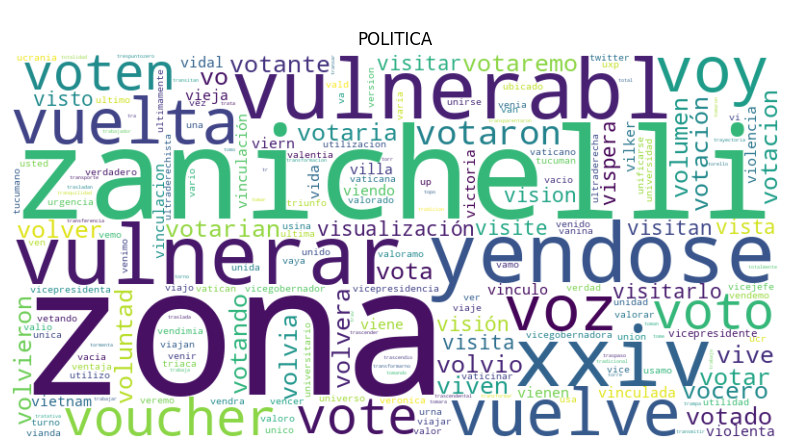

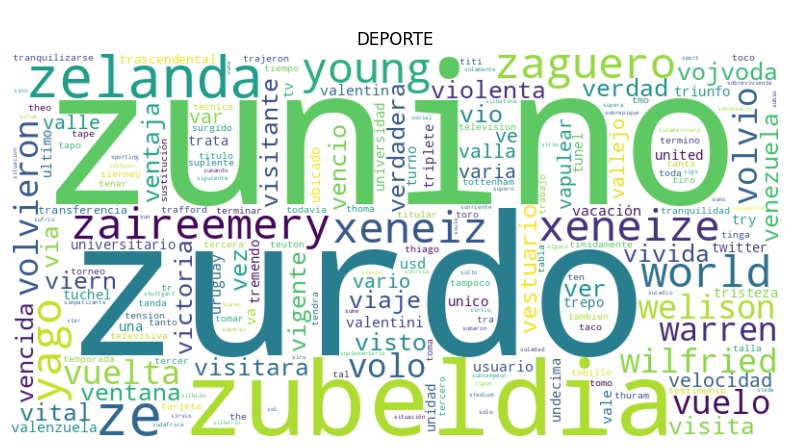

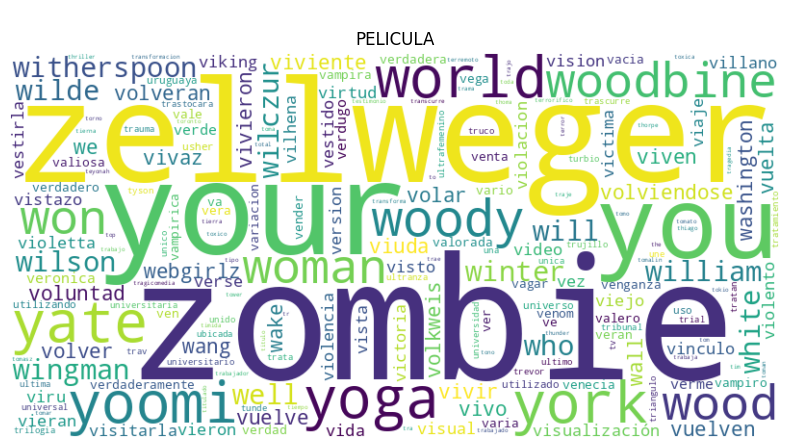

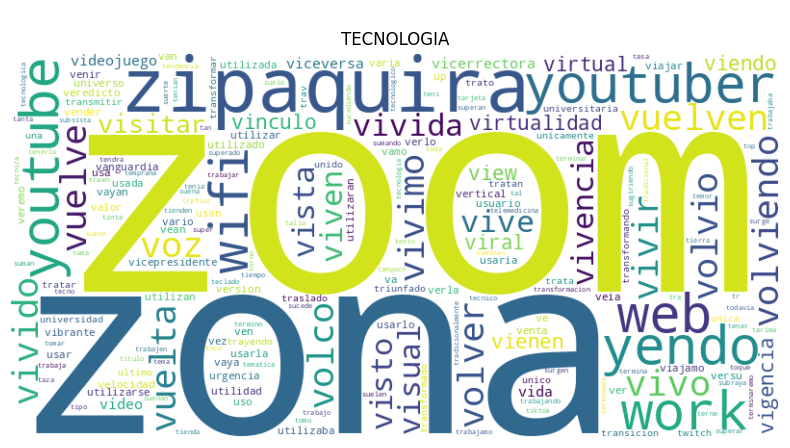

In [29]:
graficar_nube_palabras(noticias)

Vemos que aparecen para cada categoria palabras con mucha mas frecuencia que las demas. Pero que tambien aparacen palabras comunes a todos los textos.

La nube de palabras cambiara cada vez que se ejecute la funcion de extraer noticias de las paginas establecidas debido a su constante actualización. Pero en general, notamos que en la categoria politica, las mayoria de las palabras son mas comunes a las demas categorias, a excepción de los nombres propios. Esto puede explicar por que el modelo de clasificación tiende a equivocarse en esta categoria, sugiriendo que la vectorización TF-IDF pudo no haber sido la mas apropiada para evitar estos casos.

---


### ***Cuarto ejercicio***


---

Use los modelos de embedding propuestos sobre el final de la Unidad 2 para evaluar la
similitud entre los títulos de las noticias de una de las categorías.
Reflexione sobre las limitaciones del modelo en base a los resultados obtenidos, en
contraposición a los resultados que hubiera esperado obtener.

---

#### Embedding

En este caso se utilizara el modelo Sentence-Bert para lograr obtener los embeddings de los titulos de cada noticia. Esto debido a que este modelo basado en la arquitectura BERT puede entender el significado semántico de las oraciones pueden compararse con facilidad.

In [30]:
# seleccion de modelo multilignue para procesar texto en español (y palabras ingles que suelen aparecer)
modelo = SentenceTransformer('distiluse-base-multilingual-cased-v1')

Se elige la categoria y aplicamos embedding a los titulos de las noticias de la misma.

In [31]:
noticias_tecnologia = [noticia.titulo for noticia in tecnologia.get_noticias()] # obtener noticias de deportes
embeddings = modelo.encode(noticias_tecnologia, convert_to_tensor=True)

#### Comparaciones

S-Bert se caracteriza debido a que el espacio de embeddings que genera puede ser medido mediante similud de coseno, que es una forma de medir la distancia entre dos elementos del mismo espacio de forma eficiente.

El modulo ofrece la utilidad de crear una matrix que representa mide cuán similares son entre sí las noticias en términos de su significado semántico, utilizando la métrica de similitud coseno.

In [32]:
puntuaciones_coseno = util.cos_sim(embeddings, embeddings)

La siguiente función tiene intención de generar un dataframe que muestre la similitud de coseno mas altas entre dos titulos de forma ordenada.

In [33]:
def get_similarity_cos_df(puntuaciones):
    # almacena los pares de titulos a comparar
    pares = []
    for i in range(len(puntuaciones)-1):
        for j in range(i+1, len(puntuaciones)):
            pares.append({'index': [i, j], 'score': puntuaciones[i][j]})

    # Ordenamos las puntuaciones en orden decreciente
    pares = sorted(pares, key=lambda x: x['score'], reverse=True)

    # Añadimos las filas a la tabla
    tabla = []

    for par in pares[0:10]:
        i, j = par['index']
        tabla.append([noticias_tecnologia[i], noticias_tecnologia[j], f"{par['score']:.4f}"])
    columnas = ['Titulo 1', 'Titulo 2', 'Simulitud']

    # transformacion a dataframe
    df = pd.DataFrame(tabla, columns=columnas)
    return df

In [34]:
df_simil_cos = get_similarity_cos_df(puntuaciones_coseno)
df_simil_cos.head()

,Titulo 1,Titulo 2,Simulitud
0,"Perfiles Tecno: Christoph Schell, vicepresidente ejecutivo de Intel no quiere una guerra con la IA","Shawn Krause de Pixar en Perfiles Tecno: no tengo miedo a la inteligencia artificial, es una herramienta",0.5402
1,"Shawn Krause de Pixar en Perfiles Tecno: no tengo miedo a la inteligencia artificial, es una herramienta","La inteligencia artificial es compañera para la creatividad humana, no su competencia: fundador de Canva",0.4689
2,"Perfiles Tecno: Christoph Schell, vicepresidente ejecutivo de Intel no quiere una guerra con la IA","La inteligencia artificial es compañera para la creatividad humana, no su competencia: fundador de Canva",0.4101
3,"La historia de Jhon, un ingeniero con discapacidad que creó un software para hablar y ser profesor","Cómo un comediante logró el éxito profesional con la tecnología, la historia de Iván Marín",0.3868
4,"Shawn Krause de Pixar en Perfiles Tecno: no tengo miedo a la inteligencia artificial, es una herramienta",Perfiles tecno | Cómo la inteligencia artificial ayuda a las empresas y la creación de contenido SEO,0.3810


In [35]:
noticias_tecnologia

['Perfiles Tecno: Christoph Schell, vicepresidente ejecutivo de Intel no quiere una guerra con la IA',
 'Cómo triunfar en Youtube: Alejandro Gowland, líder de Creative Works de Google, reveló el secreto',
 'Así es como Movistar Arena ha modernizado Bogotá con tecnología en eventos y conciertos',
 'Shawn Krause de Pixar en Perfiles Tecno: no tengo miedo a la inteligencia artificial, es una herramienta',
 'Los trabajos con los que sueñan nuestros hijos: youtuber, gamer o influencer, estas son las razones',
 'La historia de Jhon, un ingeniero con discapacidad que creó un software para hablar y ser profesor',
 'La inteligencia artificial es compañera para la creatividad humana, no su competencia: fundador de Canva',
 'Perfiles tecno | Cómo la inteligencia artificial ayuda a las empresas y la creación de contenido SEO',
 'Cómo un comediante logró el éxito profesional con la tecnología, la historia de Iván Marín',
 'Quién está detrás de la cédula digital colombiana ']

Los resultados no parecen tan errados para este conjunto de noticias en particular. Por ejemplo, las noticias que mencionan a la inteligencia artificial en el titulo es de esperar que tengan similutes mas altas debido al topico de la noticia.

Aunque bien podriamos haber esperado una similitud mas alta entre el titulo *'Cómo triunfar en Youtube: Alejandro Gowland, líder de Creative Works de Google, reveló el secreto'*  y el titulo *'Los trabajos con los que sueñan nuestros hijos: youtuber, gamer o influencer, estas son las razones'* debido a que contextualmente refieren al mismo topico de nuevas plataformas o formas de trabajo.

En casos como estos S-BERT puede estar sufriendo la limitación de que su pre-entrenamiento pudo no haber tenido sufiente datos de ejemplo para interpretar que titulos como estos pueden estar relacionados.

En cambio en el tópico de la inteligencia Artificial si encuentra relaciones, incluso cuando en un titulo utiliza la abrevación IA para referirce a la misma.

---

### ***Quinto ejercicio***

---

Escriba un programa interactivo que, según la categoría seleccionada por el usuario,
devuelva un resumen de las noticias incluidas en ella.
Justifique la elección del modelo usado para tal fin.

---

#### Modelo

In [36]:
# tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/mT5_multilingual_XLSum")
# summarize_model = AutoModelForSeq2SeqLM.from_pretrained("csebuetnlp/mT5_multilingual_XLSum")

model = T5ForConditionalGeneration.from_pretrained('t5-large')
tokenizer = T5Tokenizer.from_pretrained('t5-large')

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning:

This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour

#### Control interactivo

In [37]:
def summarize_category(model, tokenizer, category):
    summaries = []
    for noticia in categorias[category].get_noticias():
        titulo = noticia.titulo
        texto = noticia.texto
        inputs = tokenizer.encode("summarize: " + texto, return_tensors="pt", max_length=256, truncation=True)
        summary_ids = model.generate(inputs, max_length=100, min_length=25, length_penalty=2.0, num_beams=4, early_stopping=True)
        resumen = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(resumen)
    return summaries

In [38]:
def summarize_new(model, tokenizer, new):
    WHITESPACE_HANDLER = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))

    input_ids = tokenizer(
        [WHITESPACE_HANDLER(new)],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )["input_ids"]

    output_ids = model.generate(
        input_ids=input_ids,
        max_length=84,
        no_repeat_ngram_size=2,
        num_beams=4
    )[0]

    summary = tokenizer.decode(
        output_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return summary

In [39]:
while True:
    print('Selecciona una categoria:\n1- Politica\n2- Deporte\n3- Pelicula\n4- Tecnologia\n9- Salir\n')
    category = None

    while True:
        category = input('>>> ')

        if category not in ["1", "2", "3", "4", "9"]:
            print('La opcion es incorrecta')
            continue

        break

    if category == "9":
        print('Programa finalizado')
        break

    category = int(category) - 1
    print(f'Resumiendo las noticias de la categoria {df_noticias["Categoria"].unique()[category]}\n')

    resumen = summarize_category(summarize_model, tokenizer, category)
    print(resumen, '\n')

    print('Selecciona una opcion:\n1- Elejir otra categoria\n2- Salir\n')
    option = None

    while True:
        option = input('>>> ')

        if option not in ["1", "2"]:
            print('La opcion es incorrecta')
            continue

        break

    if option == "2":
        print('Programa finalizado')
        break

    if option == "1":
        clear_output()
        continue

Selecciona una categoria:
1- Politica
2- Deporte
3- Pelicula
4- Tecnologia
9- Salir

>>> 9
Programa finalizado


#### prueba

In [45]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest

In [46]:
def summarize(text, per):
    nlp = spacy.load('en_core_web_sm')
    doc= nlp(text)
    tokens=[token.text for token in doc]
    word_frequencies={}
    for word in doc:
        if word.text.lower() not in list(STOP_WORDS):
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1
    max_frequency=max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word]=word_frequencies[word]/max_frequency
    sentence_tokens= [sent for sent in doc.sents]
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():
                    sentence_scores[sent]=word_frequencies[word.text.lower()]
                else:
                    sentence_scores[sent]+=word_frequencies[word.text.lower()]
    select_length=int(len(sentence_tokens)*per)
    summary=nlargest(select_length, sentence_scores,key=sentence_scores.get)
    final_summary=[word.text for word in summary]
    summary=''.join(final_summary)
    return summary

In [59]:
df_noticias['Texto'][2]

'¿Se puede romper algo que ya estaba roto? Juntos por el Cambio y el PRO demuestran en estas horas que es posible. Las durísimas declaraciones de Mauricio Macri para justificar su pacto con Javier Milei hicieron estallar definitivamente al partido que fundó en 2005 y a la coalición que armó en 2015 con la UCR y la Coalición Cívica, que, en realidad, ya habían detonado cuando el martes pasado salió a la luz esa negociación secreta e inconsulta que tuvo en su casa con el candidato libertario.\nEl 27 de marzo pasado, cuando renunció a la candidatura presidencial, el ex mandatario difundió un mensaje en el que rechazó los “liderazgos paternalistas” y resaltó “la importancia de los equipos” para explicar el porqué de su gesto. Son definiciones que resuenan de otra manera tras su decisión de avanzar hacia un acuerdo con Milei como si fuera el único dueño de las franquicias opositoras.\nLo que queda en claro que desde entonces demostró que había abandonado la idea de postularse para la Presid

In [60]:
summarize(df_noticias['Texto'][2], 0.025)

'Los guiños de Macri al candidato de La Libertad Avanza aparecieron la misma noche de las PASO, cuando lo felicitó y lo elogió en el escenario del búnker de JxC. Y las sospechas reaparecieron luego de que no descartó inmediatamente la propuesta de Milei de ofrecerle un cargo en su gobierno.'

# **Concluciones**
